In [1]:
%pip install git+https://github.com/metadriverse/metadrive.git
!pip install stable-baselines3  # For PPO experiments
!pip install gym  # Ensure gym is installed


  Cloning https://github.com/metadriverse/metadrive.git to /tmp/pip-req-build-zff7u3fg
  Running command git clone --filter=blob:none --quiet https://github.com/metadriverse/metadrive.git /tmp/pip-req-build-zff7u3fg
  Resolved https://github.com/metadriverse/metadrive.git to commit b908149e422f2e7715207ca1eb81380342de5681
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Created wheel for metadrive-simulator: filename=metadrive_simulator-0.4.3-py3-none-any.whl size=55022091 sha256=1eaab

In [2]:
!apt-get install -y xvfb python-opengl ffmpeg

!pip install pyvirtualdisplay

!sudo apt-get update
!sudo apt-get install -y xvfb


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,364 kB]
Get:12 htt

In [3]:
import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [4]:
class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": render},
        "medium": {"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": render},
        "hard": {"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env

In [12]:
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=32) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger

In [13]:
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models

In [15]:
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
/usr/local/lib/python3.10/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=32 and n_envs=1)
  warnings.warn(
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 21 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.009628996 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.179      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0185     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0126     |
|    std                  | 1      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 149         |
|    ep_rew_mean          | -1.02       |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 5           |
|    time_elapsed         | 3           |
|    total_timesteps      | 160         |
| train/                  |             |
|    approx_kl            | 0.017712746 |
|    clip_fraction        | 0.0969      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | 0.023       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.051      |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.037      |
|    std                  | 1           |
|    value_loss           | 0.0312      |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 112          |
|    ep_rew_mean          | -1.72        |
| time/                   |              |
|    fps                  | 61           |
|    iterations           | 7            |
|    time_elapsed         | 3            |
|    total_timesteps      | 224          |
| train/                  |              |
|    approx_kl            | 0.0022897106 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.0381      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0386       |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.00559     |
|    std                  | 0.999        |
|    value_loss           | 0.348        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | 1.05        |
| time/                   |             |
|    fps                  | 64          |
|    iterations           | 13          |
|    time_elapsed         | 6           |
|    total_timesteps      | 416         |
| train/                  |             |
|    approx_kl            | 0.002751397 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | -0.0169     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00161    |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00126    |
|    std                  | 0.99        |
|    value_loss           | 0.031       |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 95.6         |
|    ep_rew_mean          | -0.634       |
| time/                   |              |
|    fps                  | 63           |
|    iterations           | 15           |
|    time_elapsed         | 7            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0025745798 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.00652      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0613       |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.00489     |
|    std                  | 0.99         |
|    value_loss           | 0.202        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 108          |
|    ep_rew_mean          | 1.98         |
| time/                   |              |
|    fps                  | 65           |
|    iterations           | 21           |
|    time_elapsed         | 10           |
|    total_timesteps      | 672          |
| train/                  |              |
|    approx_kl            | 0.0027438272 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00239     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.179        |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00237     |
|    std                  | 0.988        |
|    value_loss           | 0.471        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 118          |
|    ep_rew_mean          | 4.87         |
| time/                   |              |
|    fps                  | 66           |
|    iterations           | 26           |
|    time_elapsed         | 12           |
|    total_timesteps      | 832          |
| train/                  |              |
|    approx_kl            | 0.0055963304 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.00699      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.291        |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00778     |
|    std                  | 0.986        |
|    value_loss           | 0.957        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 113           |
|    ep_rew_mean          | 5.29          |
| time/                   |               |
|    fps                  | 68            |
|    iterations           | 29            |
|    time_elapsed         | 13            |
|    total_timesteps      | 928           |
| train/                  |               |
|    approx_kl            | 0.00079185516 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | -0.000649     |
|    learning_rate        | 0.0003        |
|    loss                 | 0.627         |
|    n_updates            | 280           |
|    policy_gradient_loss | -0.000534     |
|    std                  | 0.986         |
|    value_loss           | 1.6           |
-------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | 4.6          |
| time/                   |              |
|    fps                  | 68           |
|    iterations           | 30           |
|    time_elapsed         | 13           |
|    total_timesteps      | 960          |
| train/                  |              |
|    approx_kl            | 0.0002332218 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.000493    |
|    learning_rate        | 0.0003       |
|    loss                 | 12           |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.0015      |
|    std                  | 0.986        |
|    value_loss           | 24.1         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | 4.89         |
| time/                   |              |
|    fps                  | 69           |
|    iterations           | 32           |
|    time_elapsed         | 14           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0014455616 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00117     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.27         |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.00675     |
|    std                  | 0.986        |
|    value_loss           | 2.63         |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 15 |
|    iterations      | 1  |
|    time_elapsed    | 2  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 22          |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.011152891 |
|    clip_fraction        | 0.075       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.17       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00172    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00797    |
|    std                  | 1    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 232       |
|    ep_rew_mean          | 0.565     |
| time/                   |           |
|    fps                  | 25        |
|    iterations           | 8         |
|    time_elapsed         | 9         |
|    total_timesteps      | 256       |
| train/                  |           |
|    approx_kl            | 0.0081481 |
|    clip_fraction        | 0.0156    |
|    clip_range           | 0.2       |
|    entropy_loss         | -2.82     |
|    explained_variance   | 0.0247    |
|    learning_rate        | 0.0003    |
|    loss                 | -0.031    |
|    n_updates            | 70        |
|    policy_gradient_loss | -0.017    |
|    std                  | 0.991     |
|    value_loss           | 0.0279    |
---------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 232       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 106          |
|    ep_rew_mean          | -2.11        |
| time/                   |              |
|    fps                  | 27           |
|    iterations           | 10           |
|    time_elapsed         | 11           |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0004710909 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | -0.00228     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0414       |
|    n_updates            | 90           |
|    policy_gradient_loss | 0.00214      |
|    std                  | 0.988        |
|    value_loss           | 0.16         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 86.8         |
|    ep_rew_mean          | -2.51        |
| time/                   |              |
|    fps                  | 28           |
|    iterations           | 11           |
|    time_elapsed         | 12           |
|    total_timesteps      | 352          |
| train/                  |              |
|    approx_kl            | 0.0041364357 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00117     |
|    learning_rate        | 0.0003       |
|    loss                 | 4.95         |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00859     |
|    std                  | 0.988        |
|    value_loss           | 11.2         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 82.2         |
|    ep_rew_mean          | -2.61        |
| time/                   |              |
|    fps                  | 30           |
|    iterations           | 13           |
|    time_elapsed         | 13           |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0064939596 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.00367      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0974       |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.0153      |
|    std                  | 0.987        |
|    value_loss           | 0.441        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 80.8        |
|    ep_rew_mean          | -2.51       |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 16          |
|    time_elapsed         | 15          |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.014454806 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.00993    |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00582    |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0174     |
|    std                  | 0.986       |
|    value_loss           | 0.109       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 92          |
|    ep_rew_mean          | -0.843      |
| time/                   |             |
|    fps                  | 32          |
|    iterations           | 21          |
|    time_elapsed         | 20          |
|    total_timesteps      | 672         |
| train/                  |             |
|    approx_kl            | 0.001569882 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | -0.0095     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.537       |
|    n_updates            | 200         |
|    policy_gradient_loss | -0.00269    |
|    std                  | 0.991       |
|    value_loss           | 1.78        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 85.6         |
|    ep_rew_mean          | -0.559       |
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 22           |
|    time_elapsed         | 22           |
|    total_timesteps      | 704          |
| train/                  |              |
|    approx_kl            | 0.0069976207 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.00434      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.29         |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.0122      |
|    std                  | 0.992        |
|    value_loss           | 6.65         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.3        |
|    ep_rew_mean          | -0.176      |
| time/                   |             |
|    fps                  | 30          |
|    iterations           | 23          |
|    time_elapsed         | 23          |
|    total_timesteps      | 736         |
| train/                  |             |
|    approx_kl            | 0.008663496 |
|    clip_fraction        | 0.0375      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0132      |
|    learning_rate        | 0.0003      |
|    loss                 | 5.16        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0143     |
|    std                  | 0.992       |
|    value_loss           | 11          |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 77           |
|    ep_rew_mean          | -0.257       |
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 25           |
|    time_elapsed         | 25           |
|    total_timesteps      | 800          |
| train/                  |              |
|    approx_kl            | 0.0044132955 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.008        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.738        |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00785     |
|    std                  | 0.993        |
|    value_loss           | 1.53         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 74.1         |
|    ep_rew_mean          | -0.261       |
| time/                   |              |
|    fps                  | 31           |
|    iterations           | 26           |
|    time_elapsed         | 26           |
|    total_timesteps      | 832          |
| train/                  |              |
|    approx_kl            | 0.0028109401 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.0023       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.63         |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00176     |
|    std                  | 0.994        |
|    value_loss           | 3.41         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 70.8         |
|    ep_rew_mean          | -0.249       |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 27           |
|    time_elapsed         | 26           |
|    total_timesteps      | 864          |
| train/                  |              |
|    approx_kl            | 0.0021501128 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00307      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.13         |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00203     |
|    std                  | 0.995        |
|    value_loss           | 10.4         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 68.7         |
|    ep_rew_mean          | -0.176       |
| time/                   |              |
|    fps                  | 32           |
|    iterations           | 28           |
|    time_elapsed         | 27           |
|    total_timesteps      | 896          |
| train/                  |              |
|    approx_kl            | 0.0020892248 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00387      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.83         |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.00748     |
|    std                  | 0.996        |
|    value_loss           | 8.23         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 66.9         |
|    ep_rew_mean          | -0.226       |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 30           |
|    time_elapsed         | 29           |
|    total_timesteps      | 960          |
| train/                  |              |
|    approx_kl            | 0.0010000337 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0147       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.75         |
|    n_updates            | 290          |
|    policy_gradient_loss | 0.00133      |
|    std                  | 0.996        |
|    value_loss           | 1.51         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 65.1         |
|    ep_rew_mean          | -0.203       |
| time/                   |              |
|    fps                  | 33           |
|    iterations           | 31           |
|    time_elapsed         | 29           |
|    total_timesteps      | 992          |
| train/                  |              |
|    approx_kl            | 0.0028744824 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00338      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.37         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00586     |
|    std                  | 0.997        |
|    value_loss           | 6.85         |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 7  |
|    iterations      | 1  |
|    time_elapsed    | 4  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 11          |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.010723459 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -5.08       |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0299     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0195     |
|    std                  | 1      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 138         |
|    ep_rew_mean          | -3.02       |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 5           |
|    time_elapsed         | 9           |
|    total_timesteps      | 160         |
| train/                  |             |
|    approx_kl            | 0.004132595 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0959     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0239     |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.00794    |
|    std                  | 0.995       |
|    value_loss           | 0.00583     |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 122         |
|    ep_rew_mean          | -2.34       |
| time/                   |             |
|    fps                  | 19          |
|    iterations           | 8           |
|    time_elapsed         | 13          |
|    total_timesteps      | 256         |
| train/                  |             |
|    approx_kl            | 0.010571815 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0413      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0371      |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.992       |
|    value_loss           | 0.126       |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 102          |
|    ep_rew_mean          | -2.6         |
| time/                   |              |
|    fps                  | 19           |
|    iterations           | 10           |
|    time_elapsed         | 16           |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0011028443 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | -0.027       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0384       |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00195     |
|    std                  | 0.99         |
|    value_loss           | 0.174        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 87.5       |
|    ep_rew_mean          | -2.76      |
| time/                   |            |
|    fps                  | 18         |
|    iterations           | 11         |
|    time_elapsed         | 19         |
|    total_timesteps      | 352        |
| train/                  |            |
|    approx_kl            | 0.00154607 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.82      |
|    explained_variance   | 0.00168    |
|    learning_rate        | 0.0003     |
|    loss                 | 1.8        |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.00113   |
|    std                  | 0.989      |
|    value_loss           | 4.09       |
----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_le

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 110         |
|    ep_rew_mean          | -0.577      |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 18          |
|    time_elapsed         | 33          |
|    total_timesteps      | 576         |
| train/                  |             |
|    approx_kl            | 0.014246395 |
|    clip_fraction        | 0.0781      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.0452     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0104     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0145     |
|    std                  | 0.986       |
|    value_loss           | 0.181       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 102         |
|    ep_rew_mean          | 0.285       |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 20          |
|    time_elapsed         | 37          |
|    total_timesteps      | 640         |
| train/                  |             |
|    approx_kl            | 0.004832292 |
|    clip_fraction        | 0.0156      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0293      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.21        |
|    n_updates            | 190         |
|    policy_gradient_loss | 0.02        |
|    std                  | 0.986       |
|    value_loss           | 2.97        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_mean          | 0.497       |
| time/                   |             |
|    fps                  | 17          |
|    iterations           | 23          |
|    time_elapsed         | 42          |
|    total_timesteps      | 736         |
| train/                  |             |
|    approx_kl            | 0.021868106 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0578      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00397     |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0166     |
|    std                  | 0.984       |
|    value_loss           | 0.121       |
-----------------------------------------
----------------------------------------
| rollout/                |        

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 101         |
|    ep_rew_mean          | 1.28        |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 26          |
|    time_elapsed         | 49          |
|    total_timesteps      | 832         |
| train/                  |             |
|    approx_kl            | 0.006625224 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.0526      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0627      |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00571    |
|    std                  | 0.985       |
|    value_loss           | 0.601       |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 96.6         |
|    ep_rew_mean          | 1.44         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 28           |
|    time_elapsed         | 53           |
|    total_timesteps      | 896          |
| train/                  |              |
|    approx_kl            | 0.0039889403 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0285       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.357        |
|    n_updates            | 270          |
|    policy_gradient_loss | -0.01        |
|    std                  | 0.983        |
|    value_loss           | 0.908        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 92.6         |
|    ep_rew_mean          | 1.48         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 29           |
|    time_elapsed         | 56           |
|    total_timesteps      | 928          |
| train/                  |              |
|    approx_kl            | 0.0023151357 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.8         |
|    explained_variance   | 0.00364      |
|    learning_rate        | 0.0003       |
|    loss                 | 6.6          |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.000602    |
|    std                  | 0.981        |
|    value_loss           | 13.3         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 87.9         |
|    ep_rew_mean          | 1.57         |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 31           |
|    time_elapsed         | 61           |
|    total_timesteps      | 992          |
| train/                  |              |
|    approx_kl            | 0.0009004008 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.79        |
|    explained_variance   | 0.0402       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.66         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00473     |
|    std                  | 0.978        |
|    value_loss           | 3.48         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 83.8        |
|    ep_rew_mean          | 1.6         |
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 32          |
|    time_elapsed         | 66          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.006021021 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.79       |
|    explained_variance   | 0.0146      |
|    learning_rate        | 0.0003      |
|    loss                 | 6.08        |
|    n_updates            | 310         |
|    policy_gradient_loss | -0.00702    |
|    std                  | 0.977       |
|    value_loss           | 12.3        |
-----------------------------------------
Performance for easy difficulty:


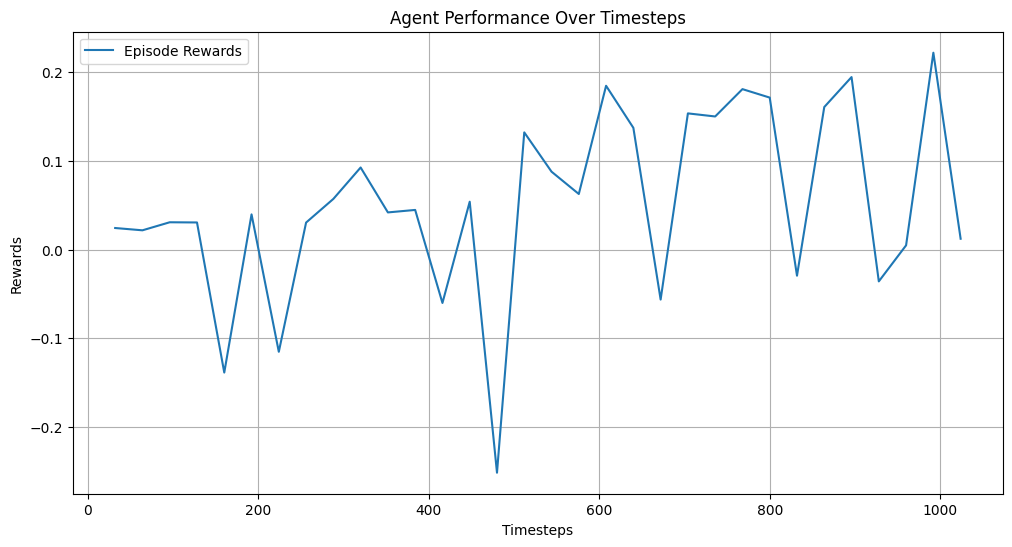

Performance for medium difficulty:


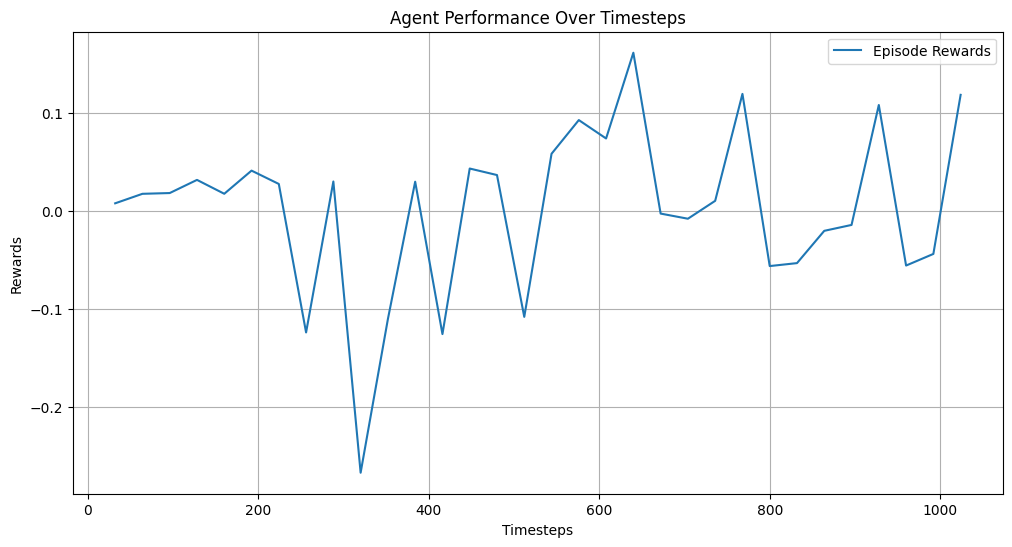

Performance for hard difficulty:


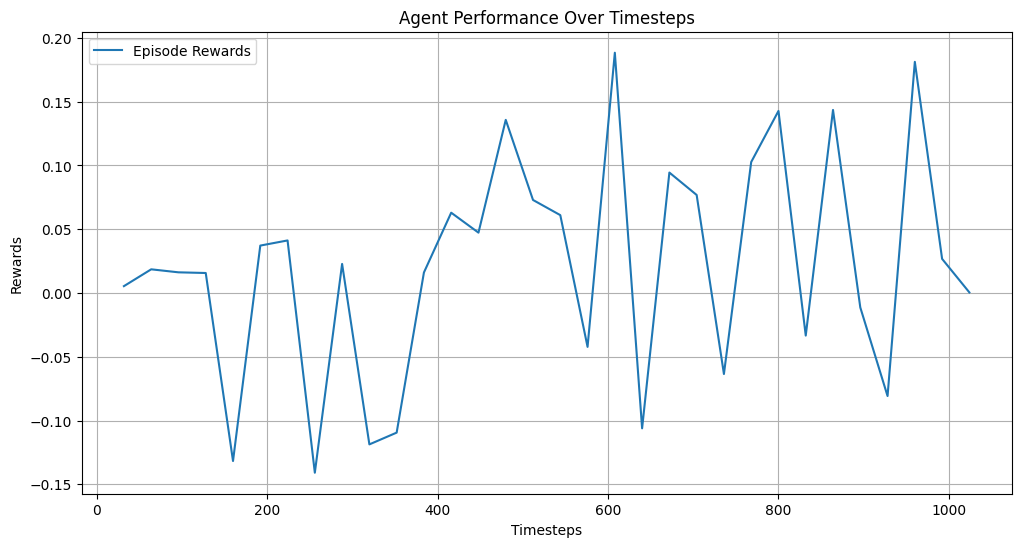

In [19]:
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=1000)

In [29]:
model = models[2][1]

In [30]:
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3
[INFO] Known Pipes: glxGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


In [ ]:
# prompt: load demo.dif and display it

import os
import numpy as np
from stable_baselines3 import PPO
from metadrive.envs import MetaDriveEnv
from pyvirtualdisplay import Display
from PIL import Image
from IPython.display import display as ipy_display, clear_output
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
# %pip install git+https://github.com/metadriverse/metadrive.git
# !pip install stable-baselines3  # For PPO experiments
# !pip install gym  # Ensure gym is installed

# !apt-get install -y xvfb python-opengl ffmpeg

# !pip install pyvirtualdisplay

# !sudo apt-get update
# !sudo apt-get install -y xvfb

class PerformanceLogger(BaseCallback):
    def __init__(self, verbose=0):
        super(PerformanceLogger, self).__init__(verbose)
        self.timesteps = []
        self.rewards = []
        self.current_reward = 0

    def reset(self):
        """Reset the logger for a new training phase."""
        self.current_reward = 0


    def _on_step(self) -> bool:
        # Sum rewards from this step
        self.current_reward += sum(self.locals["rewards"])

        # Log rewards at the end of a rollout
        if self.n_calls % self.model.n_steps == 0:
            self.timesteps.append(self.num_timesteps)
            self.rewards.append(self.current_reward / self.model.n_steps)  # Average reward per step
            self.current_reward = 0  # Reset for next rollout
        return True

# Function to create the environment
def create_environment(difficulty, render=False, monitor=True):
    configs = {
        "easy": {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": render},
        "medium": {"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": render},
        "hard": {"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": render},
    }

    base_env = MetaDriveEnv(configs[difficulty])
    if monitor:
        return Monitor(base_env)
    else:
      return base_env
def train_agent_with_transfer(env, timesteps=1000, model=None):
    logger = PerformanceLogger()
    if model is None:
        model = PPO("MlpPolicy", env, verbose=2, n_steps=32) #changing n_step param significantly changes reward results, should play ard with this
    else:
        print("Continuing training with transfer learning...")
    logger.reset()  # Reset logger for the new training phase
    model.learn(total_timesteps=timesteps, callback=logger)
    return model, logger
def plot_performance(logger, title= 'Agent Performance'):
    """
    Plot the logged performance data.
    """
    if not logger.timesteps or not logger.rewards:
        print("[ERROR] No data to plot. Ensure rewards are logged during training.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(logger.timesteps, logger.rewards, label="Episode Rewards")
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title("Agent Performance Over Timesteps")
    plt.legend()
    plt.grid()
    plt.show()
# Curriculum experiment without transfer learning
def curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=10000):
    results = []
    models = []
    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (No Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (No Transfer)")
    return results,  models
# Curriculum experiment with transfer learning
def curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=1000):
    model = None  # Start with no pretrained model
    logger = PerformanceLogger()
    results = []
    models = []

    for difficulty in difficulty_order:
        print(f"Training on {difficulty} difficulty (With Transfer)...")
        env = create_environment(difficulty, render=False)
        try:
            model, logger = train_agent_with_transfer(env, model=model, timesteps=timesteps_per_difficulty)
            results.append((difficulty, logger))
            models.append((difficulty, model))
        except Exception as e:
            print(f"Error during training on {difficulty} difficulty: {e}")
        finally:
            env.close()

    # Plot performance for each difficulty
    for difficulty, logger in results:
        print(f"Performance for {difficulty} difficulty:")
        plot_performance(logger, f"Performance on {difficulty} (With Transfer)")
    return results, models
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
# print("Running Curriculum Experiment WITHOUT Transfer Learning...")
# curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# # Experiment with transfer learning
# print("Running Curriculum Experiment WITH Transfer Learning...")
# curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)
results, models = curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=1000)
model = models[2][1]
env = create_environment('medium', render=False, monitor=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

In [ ]:
env = MetaDriveEnv( {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})

e = Monitor(env)
dir(e)
e.render(mode="topdown",
                    window=False,
                    screen_size=(600, 600),
                    camera_position=(50, 50))

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None


TypeError: render() got an unexpected keyword argument 'mode'

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


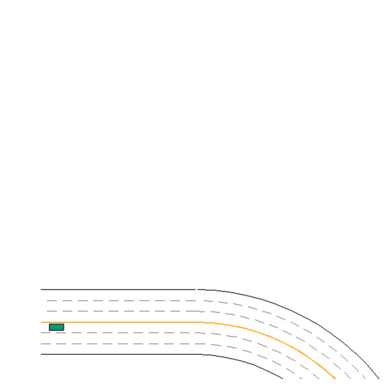

In [ ]:
try:
    env.close()
except:
    pass
total_reward = 0
env = MetaDriveEnv( {"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
model = PPO("MlpPolicy",
            train_env,
            n_steps=4096,
            verbose=1)
try:
    e = Monitor(env)
    env = e.unwrapped
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()
plt.axis("off")
plt.imshow(ret)

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
from metadrive.envs import MetaDriveEnv
from metadrive.policy.lange_change_policy import LaneChangePolicy
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from metadrive.component.map.base_map import BaseMap
from metadrive.utils import generate_gif
from IPython.display import Image

def create_env(need_monitor=False):
    env = MetaDriveEnv(dict(map="C",
                      # This policy setting simplifies the task
                      discrete_action=True,
                      discrete_throttle_dim=3,
                      discrete_steering_dim=3,
                      horizon=500,
                      # scenario setting
                      random_spawn_lane_index=False,
                      num_scenarios=1,
                      start_seed=5,
                      traffic_density=0,
                      accident_prob=0,
                      log_level=50))
    if need_monitor:
        env = Monitor(env)
    return env

In [ ]:
env.close()

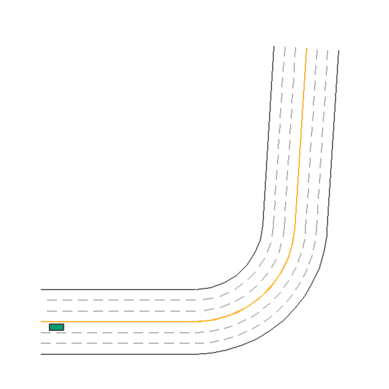

In [ ]:
env=create_env()
env.reset()
ret = env.render(mode="topdown",
                 window=False,
                 screen_size=(600, 600),
                 camera_position=(50, 50))
env.close()
plt.axis("off")
plt.imshow(ret)

In [ ]:
timesteps_per_difficulty=1000
difficulty = "easy"
results = []
env = create_environment(difficulty, render=False)
try:
    model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
    results.append((difficulty, logger))
    obs, _ = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

In [ ]:
try:
    env.close()
except:
    pass
env = create_environment("easy", render=False)
try:
    env.reset()
    ret = env.render(
        mode="topdown",
                    window=False,
                    screen_size=(600, 600),
                    camera_position=(50, 50))
finally:
    env.close()
plt.axis("off")
plt.imshow(ret)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3


Exception: Attempt to spawn multiple ShowBase instances!

In [ ]:
env = create_environment(difficulty, render=False)
obs, _ = env.reset()
try:
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3


Exception: Attempt to spawn multiple ShowBase instances!

: 

In [ ]:
timesteps_per_difficulty=1000
difficulty = "easy"
results = []
env = create_environment(difficulty, render=False)
try:
    model, logger = train_agent_with_transfer(env, timesteps=timesteps_per_difficulty)
    results.append((difficulty, logger))
    obs, _ = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, _, info = env.step(action)
        # total_reward += reward
        ret = env.render(mode="topdown",
                         screen_record=True,
                         window=False,
                         screen_size=(600, 600),
                         camera_position=(50, 50))
        if done:
            # print("episode_reward", total_reward)
            break

    env.top_down_renderer.generate_gif()
finally:
    env.close()

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 72 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 101         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.008032592 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.349      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00238    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0067     |
|    std                  | 1           |
|    value_loss           | 0.0184    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 302        |
|    ep_rew_mean          | 4.28       |
| time/                   |            |
|    fps                  | 138        |
|    iterations           | 10         |
|    time_elapsed         | 2          |
|    total_timesteps      | 320        |
| train/                  |            |
|    approx_kl            | 0.00643057 |
|    clip_fraction        | 0.0156     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.85      |
|    explained_variance   | 0.018      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0637     |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0171    |
|    std                  | 1          |
|    value_loss           | 0.423      |
----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 168          |
|    ep_rew_mean          | 1.37         |
| time/                   |              |
|    fps                  | 137          |
|    iterations           | 11           |
|    time_elapsed         | 2            |
|    total_timesteps      | 352          |
| train/                  |              |
|    approx_kl            | 0.0039157253 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.014        |
|    learning_rate        | 0.0003       |
|    loss                 | 4.66         |
|    n_updates            | 100          |
|    policy_gradient_loss | 0.000467     |
|    std                  | 1            |
|    value_loss           | 10.5         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 159          |
|    ep_rew_mean          | 5.33         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 15           |
|    time_elapsed         | 3            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0030155852 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.00127     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.365        |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.0033       |
|    std                  | 1            |
|    value_loss           | 1.48         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | 4.76         |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 18           |
|    time_elapsed         | 4            |
|    total_timesteps      | 576          |
| train/                  |              |
|    approx_kl            | 0.0034488663 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0286       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0975       |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00735     |
|    std                  | 1            |
|    value_loss           | 0.394        |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 125          |
|    ep_rew_mean          | 5.35         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 20           |
|    time_elapsed         | 5            |
|    total_timesteps      | 640          |
| train/                  |              |
|    approx_kl            | 0.0008909926 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.027        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.48         |
|    n_updates            | 190          |
|    policy_gradient_loss | -0.00226     |
|    std                  | 0.998        |
|    value_loss           | 3.33         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 114          |
|    ep_rew_mean          | 5.81         |
| time/                   |              |
|    fps                  | 126          |
|    iterations           | 22           |
|    time_elapsed         | 5            |
|    total_timesteps      | 704          |
| train/                  |              |
|    approx_kl            | 0.0001265388 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0323       |
|    learning_rate        | 0.0003       |
|    loss                 | 3.52         |
|    n_updates            | 210          |
|    policy_gradient_loss | 0.00123      |
|    std                  | 0.998        |
|    value_loss           | 7.49         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 107          |
|    ep_rew_mean          | 5.96         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 24           |
|    time_elapsed         | 6            |
|    total_timesteps      | 768          |
| train/                  |              |
|    approx_kl            | 5.484186e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0395       |
|    learning_rate        | 0.0003       |
|    loss                 | 2.4          |
|    n_updates            | 230          |
|    policy_gradient_loss | 0.00127      |
|    std                  | 0.997        |
|    value_loss           | 5.14         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | 6.01         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 26           |
|    time_elapsed         | 6            |
|    total_timesteps      | 832          |
| train/                  |              |
|    approx_kl            | 0.0036225468 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00138     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.483        |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.0129      |
|    std                  | 0.996        |
|    value_loss           | 1.18         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 94.9         |
|    ep_rew_mean          | 5.09         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 27           |
|    time_elapsed         | 6            |
|    total_timesteps      | 864          |
| train/                  |              |
|    approx_kl            | 0.0045335162 |
|    clip_fraction        | 0.00937      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00952      |
|    learning_rate        | 0.0003       |
|    loss                 | 5.1          |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00401     |
|    std                  | 0.995        |
|    value_loss           | 10.5         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 92.6         |
|    ep_rew_mean          | 5.17         |
| time/                   |              |
|    fps                  | 124          |
|    iterations           | 29           |
|    time_elapsed         | 7            |
|    total_timesteps      | 928          |
| train/                  |              |
|    approx_kl            | 0.0020335894 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0086       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.09         |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00786     |
|    std                  | 0.995        |
|    value_loss           | 2.35         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 90.8          |
|    ep_rew_mean          | 5.42          |
| time/                   |               |
|    fps                  | 125           |
|    iterations           | 32            |
|    time_elapsed         | 8             |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.1753291e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | 0.016         |
|    learning_rate        | 0.0003        |
|    loss                 | 2.03          |
|    n_updates            | 310           |
|    policy_gradient_loss | 0.00171       |
|    std                  | 0.994         |
|    value_loss           | 4.92          |
-------------------------------------------


TypeError: render() got an unexpected keyword argument 'mode'

In [ ]:
Image(open("demo.gif", 'rb').read())

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITHOUT Transfer Learning...
Training on easy difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 85 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0148714315 |
|    clip_fraction        | 0.0531       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.188       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0521      |
|    n_updates            | 10           |
|  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 119          |
|    ep_rew_mean          | -2.39        |
| time/                   |              |
|    fps                  | 132          |
|    iterations           | 4            |
|    time_elapsed         | 0            |
|    total_timesteps      | 128          |
| train/                  |              |
|    approx_kl            | 0.0052361134 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0162       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.00911      |
|    n_updates            | 30           |
|    policy_gradient_loss | -0.0128      |
|    std                  | 1            |
|    value_loss           | 0.0938       |
------------------------------------------
-----------------------------------------
| rollout/  

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 93           |
|    ep_rew_mean          | -1.88        |
| time/                   |              |
|    fps                  | 139          |
|    iterations           | 6            |
|    time_elapsed         | 1            |
|    total_timesteps      | 192          |
| train/                  |              |
|    approx_kl            | 0.0014298856 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.0149       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.197        |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.00165     |
|    std                  | 1            |
|    value_loss           | 0.651        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 89.3       |
|    ep_rew_mean          | -1.39      |
| time/                   |            |
|    fps                  | 149        |
|    iterations           | 9          |
|    time_elapsed         | 1          |
|    total_timesteps      | 288        |
| train/                  |            |
|    approx_kl            | 0.01488691 |
|    clip_fraction        | 0.0594     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0141     |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0282     |
|    n_updates            | 80         |
|    policy_gradient_loss | -0.011     |
|    std                  | 0.997      |
|    value_loss           | 0.132      |
----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 86.8          |
|    ep_rew_mean          | -1.56         |
| time/                   |               |
|    fps                  | 151           |
|    iterations           | 11            |
|    time_elapsed         | 2             |
|    total_timesteps      | 352           |
| train/                  |               |
|    approx_kl            | 0.00013663061 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.83         |
|    explained_variance   | -0.0243       |
|    learning_rate        | 0.0003        |
|    loss                 | 0.114         |
|    n_updates            | 100           |
|    policy_gradient_loss | 0.00204       |
|    std                  | 0.997         |
|    value_loss           | 0.31          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 82.4         |
|    ep_rew_mean          | -1.72        |
| time/                   |              |
|    fps                  | 150          |
|    iterations           | 13           |
|    time_elapsed         | 2            |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0034064613 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | -0.00214     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0628       |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00817     |
|    std                  | 0.999        |
|    value_loss           | 0.218        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.4         |
|    ep_rew_mean          | -2.39        |
| time/                   |              |
|    fps                  | 145          |
|    iterations           | 14           |
|    time_elapsed         | 3            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0026339982 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00171      |
|    learning_rate        | 0.0003       |
|    loss                 | 1.54         |
|    n_updates            | 130          |
|    policy_gradient_loss | 0.00655      |
|    std                  | 1            |
|    value_loss           | 3.36         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 62.2         |
|    ep_rew_mean          | -2.25        |
| time/                   |              |
|    fps                  | 146          |
|    iterations           | 16           |
|    time_elapsed         | 3            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0056114886 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | 0.00232      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.112        |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00918     |
|    std                  | 1            |
|    value_loss           | 0.292        |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 23 |
|    iterations      | 1  |
|    time_elapsed    | 1  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 36          |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.007510271 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.528      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00742    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00721    |
|    std                  | 1    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 272          |
|    ep_rew_mean          | 5.74         |
| time/                   |              |
|    fps                  | 49           |
|    iterations           | 9            |
|    time_elapsed         | 5            |
|    total_timesteps      | 288          |
| train/                  |              |
|    approx_kl            | 0.0039082877 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.0291      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.151        |
|    n_updates            | 80           |
|    policy_gradient_loss | -0.00623     |
|    std                  | 1.01         |
|    value_loss           | 0.845        |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 127          |
|    ep_rew_mean          | 2.25         |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 12           |
|    time_elapsed         | 7            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0019683018 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.00483      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.211        |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00663     |
|    std                  | 1            |
|    value_loss           | 1.08         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 89.2        |
|    ep_rew_mean          | 0.348       |
| time/                   |             |
|    fps                  | 48          |
|    iterations           | 14          |
|    time_elapsed         | 9           |
|    total_timesteps      | 448         |
| train/                  |             |
|    approx_kl            | 0.012951184 |
|    clip_fraction        | 0.05        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 0.0506      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.00423     |
|    n_updates            | 130         |
|    policy_gradient_loss | -0.0305     |
|    std                  | 1           |
|    value_loss           | 0.177       |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 77           |
|    ep_rew_mean          | -0.327       |
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 15           |
|    time_elapsed         | 9            |
|    total_timesteps      | 480          |
| train/                  |              |
|    approx_kl            | 0.0053646453 |
|    clip_fraction        | 0.00625      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.000731    |
|    learning_rate        | 0.0003       |
|    loss                 | 9.69         |
|    n_updates            | 140          |
|    policy_gradient_loss | 0.0163       |
|    std                  | 1            |
|    value_loss           | 20.5         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 63.9         |
|    ep_rew_mean          | -0.914       |
| time/                   |              |
|    fps                  | 47           |
|    iterations           | 16           |
|    time_elapsed         | 10           |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0013963338 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | -0.000168    |
|    learning_rate        | 0.0003       |
|    loss                 | 4.77         |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00359     |
|    std                  | 1            |
|    value_loss           | 10.7         |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (No Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 12 |
|    iterations      | 1  |
|    time_elapsed    | 2  |
|    total_timesteps | 32 |
---------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 2          |
|    time_elapsed         | 3          |
|    total_timesteps      | 64         |
| train/                  |            |
|    approx_kl            | 0.00767746 |
|    clip_fraction        | 0.0469     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.84      |
|    explained_variance   | -0.193     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0201    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.0141    |
|    std                  | 1          |
|    value

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 311         |
|    ep_rew_mean          | 11.7        |
| time/                   |             |
|    fps                  | 20          |
|    iterations           | 10          |
|    time_elapsed         | 15          |
|    total_timesteps      | 320         |
| train/                  |             |
|    approx_kl            | 0.010824438 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.0422     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.00215    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00855    |
|    std                  | 0.998       |
|    value_loss           | 0.232       |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 218        |
|    ep_rew_mean          | 8.5        |
| time/                   |            |
|    fps                  | 20         |
|    iterations           | 14         |
|    time_elapsed         | 21         |
|    total_timesteps      | 448        |
| train/                  |            |
|    approx_kl            | 0.01331882 |
|    clip_fraction        | 0.0437     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.83      |
|    explained_variance   | 0.0124     |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0174    |
|    n_updates            | 130        |
|    policy_gradient_loss | -0.0132    |
|    std                  | 0.997      |
|    value_loss           | 0.0571     |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_me

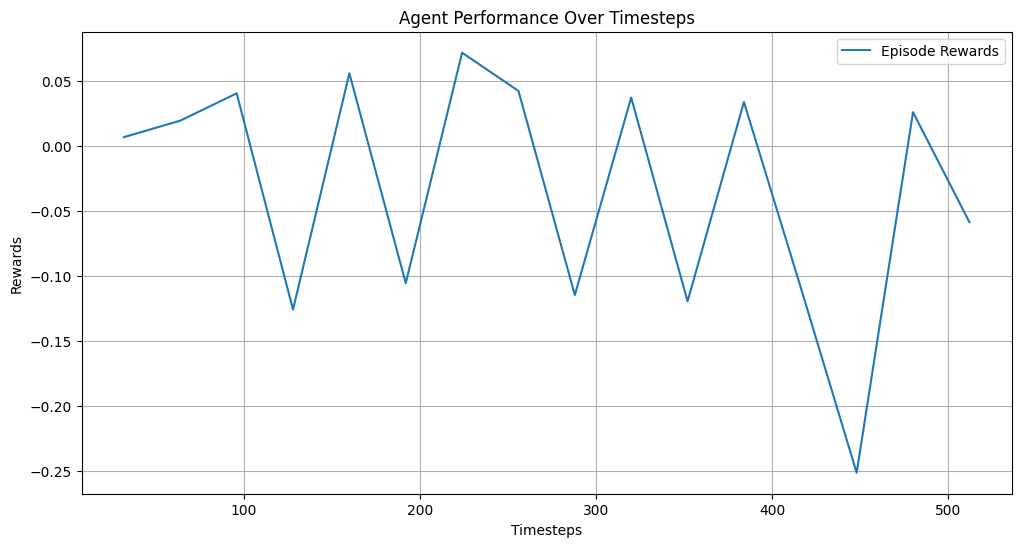

Performance for medium difficulty:


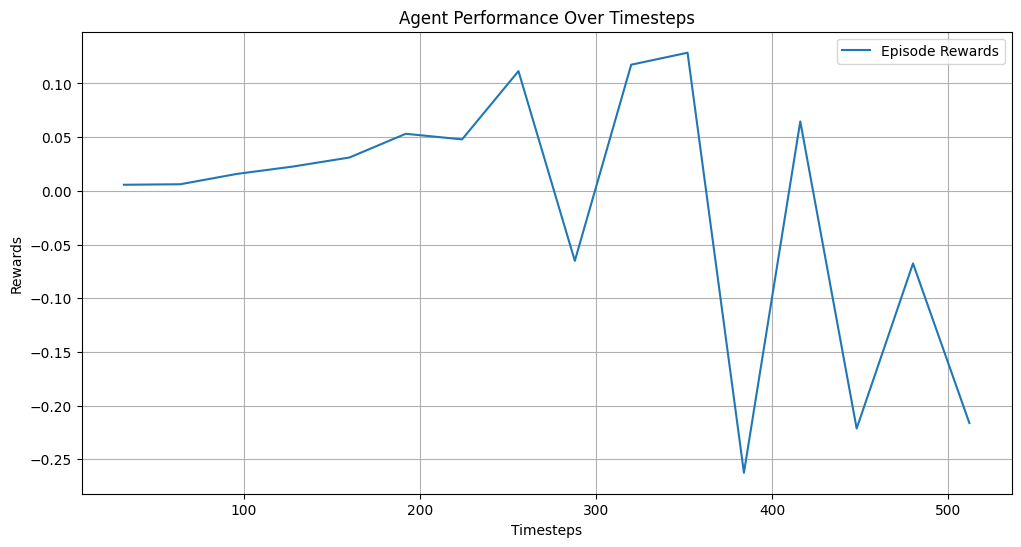

Performance for hard difficulty:


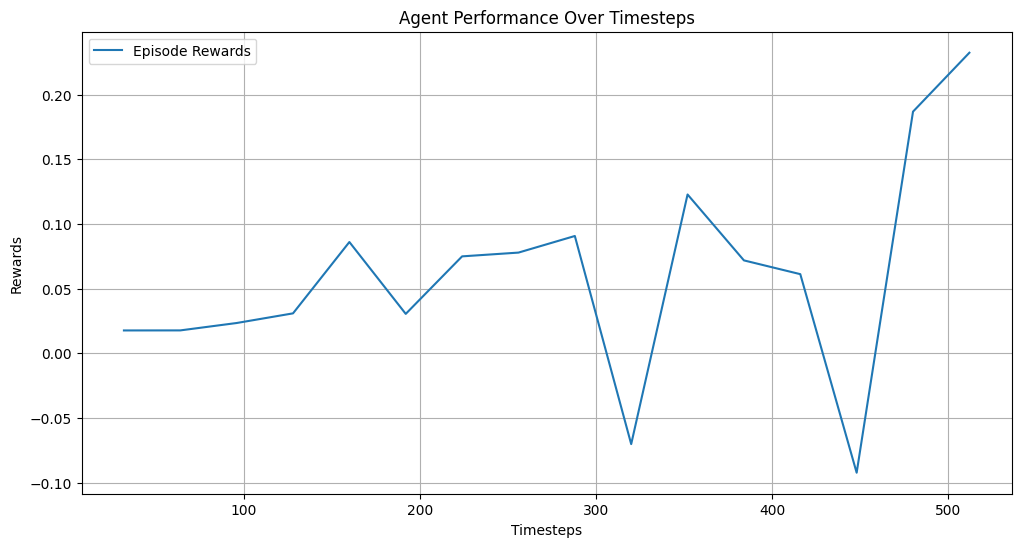

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Running Curriculum Experiment WITH Transfer Learning...
Training on easy difficulty (With Transfer)...
Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 62 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.008222368 |
|    clip_fraction        | 0.0406      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.348      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0176     |
|    n_updates            | 10          |
|    policy_gradien

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 301          |
|    ep_rew_mean          | 3.18         |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 10           |
|    time_elapsed         | 2            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0077716317 |
|    clip_fraction        | 0.0219       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.0139       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00773     |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.0127      |
|    std                  | 0.995        |
|    value_loss           | 0.0644       |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 185          |
|    ep_rew_mean          | 0.558        |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 12           |
|    time_elapsed         | 3            |
|    total_timesteps      | 384          |
| train/                  |              |
|    approx_kl            | 0.0016949177 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00263      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0542       |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00246     |
|    std                  | 0.994        |
|    value_loss           | 0.255        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 104          |
|    ep_rew_mean          | -1.57        |
| time/                   |              |
|    fps                  | 114          |
|    iterations           | 13           |
|    time_elapsed         | 3            |
|    total_timesteps      | 416          |
| train/                  |              |
|    approx_kl            | 0.0011942256 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.83        |
|    explained_variance   | 0.00094      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.17         |
|    n_updates            | 120          |
|    policy_gradient_loss | 0.0013       |
|    std                  | 0.994        |
|    value_loss           | 6.95         |
------------------------------------------
-------------------------------------------
| rollout/

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.6         |
|    ep_rew_mean          | -1.75        |
| time/                   |              |
|    fps                  | 117          |
|    iterations           | 16           |
|    time_elapsed         | 4            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 0.0001023002 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.82        |
|    explained_variance   | 0.00488      |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0373       |
|    n_updates            | 150          |
|    policy_gradient_loss | -3.09e-05    |
|    std                  | 0.991        |
|    value_loss           | 0.125        |
------------------------------------------


[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on medium difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 67 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 64          |
| train/                  |             |
|    approx_kl            | 0.006417265 |
|    clip_fraction        | 0.00625     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.00509    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.164       |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0166     |
|    std                  | 0.988    

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 164         |
|    ep_rew_mean          | 9.61        |
| time/                   |             |
|    fps                  | 103         |
|    iterations           | 6           |
|    time_elapsed         | 1           |
|    total_timesteps      | 192         |
| train/                  |             |
|    approx_kl            | 0.010501722 |
|    clip_fraction        | 0.0469      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000542   |
|    learning_rate        | 0.0003      |
|    loss                 | 0.383       |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.0292     |
|    std                  | 0.989       |
|    value_loss           | 1.51        |
-----------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 72          |
|    ep_rew_mean          | 2.17        |
| time/                   |             |
|    fps                  | 95          |
|    iterations           | 7           |
|    time_elapsed         | 2           |
|    total_timesteps      | 224         |
| train/                  |             |
|    approx_kl            | 0.021476252 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.000778    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.44        |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0151     |
|    std                  | 0.99        |
|    value_loss           | 6.94        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75.8        |
|    ep_rew_mean          | 3.87        |
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 12          |
|    time_elapsed         | 4           |
|    total_timesteps      | 384         |
| train/                  |             |
|    approx_kl            | 0.004140351 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.82       |
|    explained_variance   | 0.0121      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.263       |
|    n_updates            | 270         |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.989       |
|    value_loss           | 1.1         |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 70           |
|    ep_rew_mean          | 2.97         |
| time/                   |              |
|    fps                  | 94           |
|    iterations           | 14           |
|    time_elapsed         | 4            |
|    total_timesteps      | 448          |
| train/                  |              |
|    approx_kl            | 0.0052017495 |
|    clip_fraction        | 0.00313      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00854     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.0649       |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.0107      |
|    std                  | 0.986        |
|    value_loss           | 0.263        |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.
[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59.9        |
|    ep_rew_mean          | 1.99        |
| time/                   |             |
|    fps                  | 93          |
|    iterations           | 15          |
|    time_elapsed         | 5           |
|    total_timesteps      | 480         |
| train/                  |             |
|    approx_kl            | 0.012044935 |
|    clip_fraction        | 0.0437      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000261   |
|    learning_rate        | 0.0003      |
|    loss                 | 4.74        |
|    n_updates            | 300         |
|    policy_gradient_loss | -0.0172     |
|    std                  | 0.986       |
|    value_loss           | 9.58        |
-----------------------------------------
-----------------------------------------
| rollout/                |       

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.2.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector()]
[INFO] Render Mode: none
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.2.3
[INFO] Known Pipes: wglGraphicsPipe
[INFO] Start Scenario Index: 0, Num Scenarios : 1


Training on hard difficulty (With Transfer)...
Continuing training with transfer learning...
---------------------------
| time/              |    |
|    fps             | 69 |
|    iterations      | 1  |
|    time_elapsed    | 0  |
|    total_timesteps | 32 |
---------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 87           |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 64           |
| train/                  |              |
|    approx_kl            | 0.0010298584 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | 0.0012       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.212        |
|    n_updates            | 330          |
|    policy_gradient_loss | 0.00292      |
|    std               

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 116           |
|    ep_rew_mean          | 16.2          |
| time/                   |               |
|    fps                  | 85            |
|    iterations           | 4             |
|    time_elapsed         | 1             |
|    total_timesteps      | 128           |
| train/                  |               |
|    approx_kl            | 0.00039777532 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.81         |
|    explained_variance   | 0.00527       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23          |
|    n_updates            | 350           |
|    policy_gradient_loss | -0.00295      |
|    std                  | 0.984         |
|    value_loss           | 3.27          |
-------------------------------------------
--------------------------------

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 96           |
|    ep_rew_mean          | 14.2         |
| time/                   |              |
|    fps                  | 89           |
|    iterations           | 6            |
|    time_elapsed         | 2            |
|    total_timesteps      | 192          |
| train/                  |              |
|    approx_kl            | 0.0016509015 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00371     |
|    learning_rate        | 0.0003       |
|    loss                 | 0.681        |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.005       |
|    std                  | 0.985        |
|    value_loss           | 1.55         |
------------------------------------------
------------------------------------------
| rollout/ 

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 97.3         |
|    ep_rew_mean          | 13.4         |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 10           |
|    time_elapsed         | 3            |
|    total_timesteps      | 320          |
| train/                  |              |
|    approx_kl            | 0.0008036997 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.81        |
|    explained_variance   | -0.00051     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.02         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00145     |
|    std                  | 0.985        |
|    value_loss           | 2.57         |
------------------------------------------


[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 88          |
|    ep_rew_mean          | 12.6        |
| time/                   |             |
|    fps                  | 94          |
|    iterations           | 11          |
|    time_elapsed         | 3           |
|    total_timesteps      | 352         |
| train/                  |             |
|    approx_kl            | 0.005817162 |
|    clip_fraction        | 0.00937     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | -0.000258   |
|    learning_rate        | 0.0003      |
|    loss                 | 6.9         |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00438    |
|    std                  | 0.982       |
|    value_loss           | 13.8        |
-----------------------------------------
------------------------------------------
| rollout/                |      

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 81.4        |
|    ep_rew_mean          | 11.1        |
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 13          |
|    time_elapsed         | 4           |
|    total_timesteps      | 416         |
| train/                  |             |
|    approx_kl            | 0.001254417 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.8        |
|    explained_variance   | 0.00475     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.28        |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.000612   |
|    std                  | 0.981       |
|    value_loss           | 2.62        |
-----------------------------------------
-------------------------------------------
| rollout/                |     

[INFO] Episode ended! Scenario Index: 0 Reason: out_of_road.


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 85            |
|    ep_rew_mean          | 12.2          |
| time/                   |               |
|    fps                  | 95            |
|    iterations           | 16            |
|    time_elapsed         | 5             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00036948547 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.8          |
|    explained_variance   | 0.000629      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.08          |
|    n_updates            | 470           |
|    policy_gradient_loss | -0.000256     |
|    std                  | 0.98          |
|    value_loss           | 4.64          |
-------------------------------------------
Performance for easy difficulty:

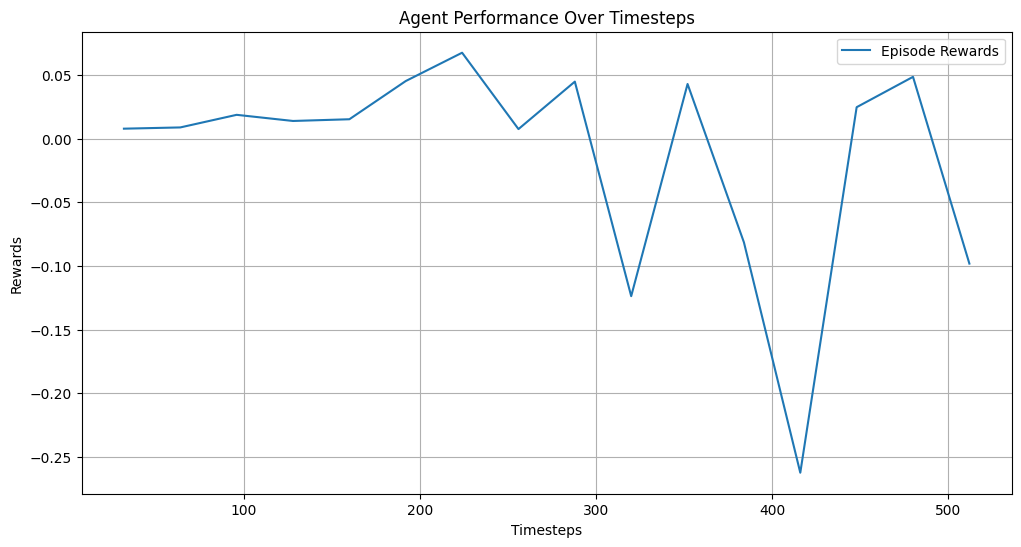

Performance for medium difficulty:


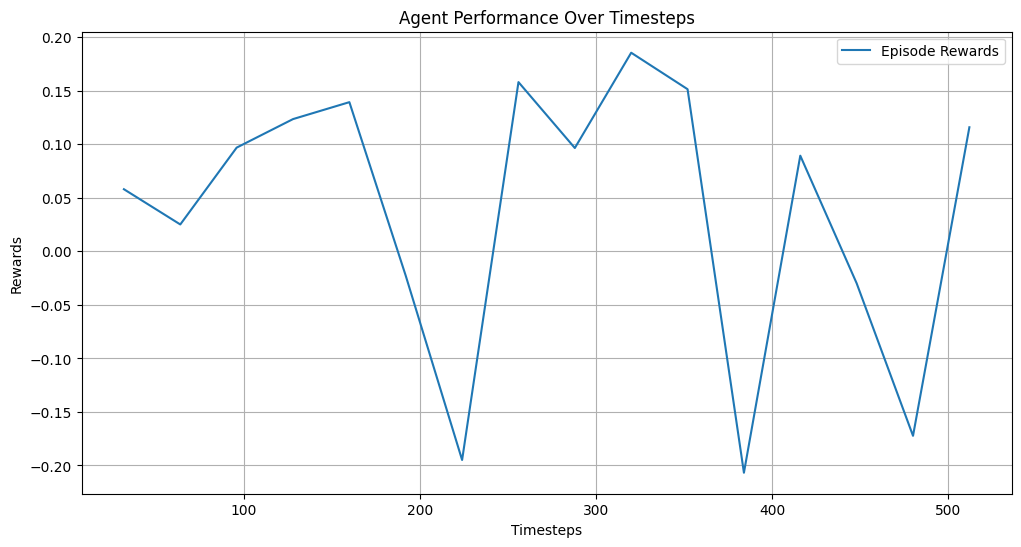

Performance for hard difficulty:


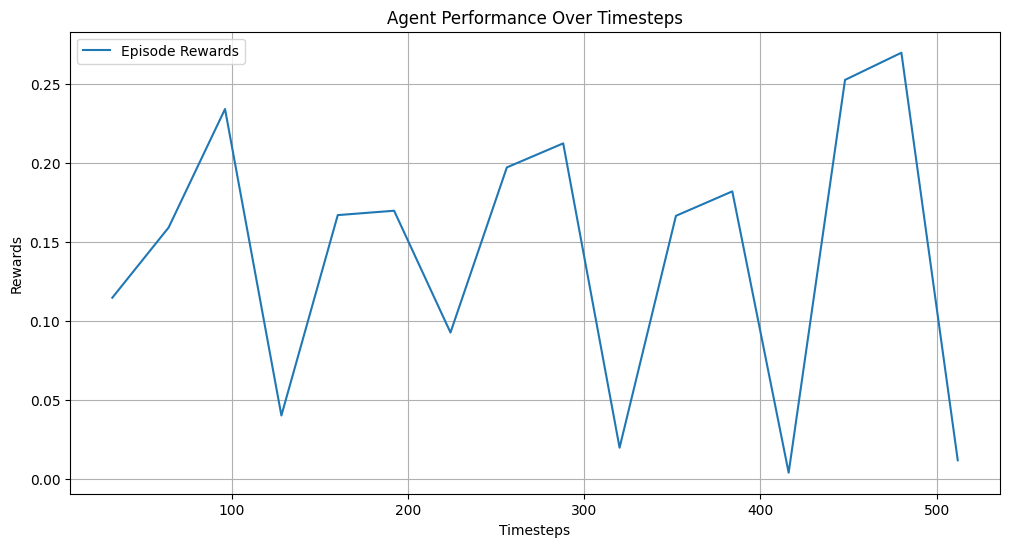

In [ ]:
# Run the curriculum experiments
difficulty_order = ["easy", "medium", "hard"]

# Experiment without transfer learning
print("Running Curriculum Experiment WITHOUT Transfer Learning...")
curriculum_experiment_no_transfer(difficulty_order, timesteps_per_difficulty=500)

# Experiment with transfer learning
print("Running Curriculum Experiment WITH Transfer Learning...")
curriculum_experiment_with_transfer(difficulty_order, timesteps_per_difficulty=500)

# Code for simulator, not tested

In [ ]:
from pyvirtualdisplay import Display

# Set up the virtual display
display = Display(visible=0, size=(972, 729))
display.start()

In [ ]:
def show_frame(env, step, interval=10):
    if step % interval == 0:  # Show every 'interval' steps
        base_env = env.unwrapped  # Access the underlying MetaDriveEnv
        frame = base_env.render(mode="rgb_array")
        if frame is None:
            print("[WARNING] Frame rendering failed. Ensure 'use_render=True' in the configuration.")
            return
        img = Image.fromarray(frame)
        clear_output(wait=True)
        display(img)

In [ ]:
def reset_environment(env, difficulty):
    base_env = env.unwrapped
    if difficulty == "easy":
        base_env.config.update({"map": 3, "traffic_density": 0.1, "random_lane_width": False, "use_render": False})
    elif difficulty == "medium":
        base_env.config.update({"map": 5, "traffic_density": 0.3, "random_lane_width": True, "use_render": False})
    elif difficulty == "hard":
        base_env.config.update({"map": 7, "traffic_density": 0.5, "random_lane_width": True, "use_render": False})
    base_env.reset()


In [ ]:
def evaluate_model_with_visualization(model, env, num_episodes=5):
  rewards = []
  for episode in range(num_episodes):
      obs, _ = env.reset()
      done = False
      total_reward = 0
      step = 0
      while not done:
          action, _ = model.predict(obs, deterministic=True)
          obs, reward, done, truncated, info = env.step(action)
          total_reward += reward
          show_frame(env, step)  # Display the frame every few steps
          step += 1
      rewards.append(total_reward)
  return rewards

SyntaxError: incomplete input (<ipython-input-14-59946a11ebd1>, line 1)

In [ ]:
def evaluate_and_save_video(model, env, num_episodes=1, output_dir="./video"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    frames = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            total_reward += reward
            frame = env.unwrapped.render(mode="rgb_array")
            if frame is not None:
                frames.append(Image.fromarray(frame))
        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    # Save video as GIF
    video_path = os.path.join(output_dir, "evaluation.gif")
    frames[0].save(
        video_path,
        save_all=True,
        append_images=frames[1:],
        duration=50,  # Duration of each frame in milliseconds
        loop=0,
    )
    print(f"Video saved at: {video_path}")

In [ ]:
def curriculum_experiment_reuse_env(order):
    """
    Runs a curriculum learning experiment using a single reusable environment.
    """
    results = []
    env = create_environment("easy", render=True)  # Use a single environment

    for difficulty in order:
        print(f"Training on {difficulty} difficulty...")
        reset_environment(env, difficulty)
        model = train_agent(env, timesteps=100)
        evaluate_and_save_video(model, env, num_episodes=1)  # Save video for 1 episode
        results.append((difficulty, [0]))  # Placeholder for rewards in quick test

    env.close()
    return results

In [ ]:
def summarize_results(results):
    """
    Summarizes the results of the experiment.
    """
    for difficulty, rewards in results:
        avg_reward = np.mean(rewards)
        std_reward = np.std(rewards)
        print(f"Difficulty: {difficulty}, Avg Reward: {avg_reward:.2f}, Std Dev: {std_reward:.2f}")

results = curriculum_experiment_reuse_env(["easy", "medium", "hard"])
summarize_results(results)

[INFO] Environment: MetaDriveEnv
[INFO] MetaDrive version: 0.4.3
[INFO] Sensors: [lidar: Lidar(), side_detector: SideDetector(), lane_line_detector: LaneLineDetector(), main_camera: MainCamera(1200, 900), dashboard: DashBoard()]
[INFO] Render Mode: onscreen
[INFO] Horizon (Max steps per agent): None
[INFO] Assets version: 0.4.3


Training on easy difficulty...


[INFO] Known Pipes: glxGraphicsPipe
[WARNING] Since your screen is too small (1080, 810), we resize the window to (972, 729). (engine_core.py:230)
[INFO] Start Scenario Index: 0, Num Scenarios : 1
